In [1]:
%matplotlib inline

%load_ext autoreload
%autoreload 2

from matplotlib.gridspec import GridSpec
import matplotlib.pyplot as plt
from scipy.misc import imread, imresize
import pandas as pd
import glob
import pickle

from stn.conv_model import conv_model
from stn.conv_model import conv_model_no_color_adjust
from sklearn.utils import resample
from lib.utils import load_gtsrb
from keras.metrics import sparse_categorical_accuracy

from parameters import *
from small_net import *

Using TensorFlow backend.


In [2]:
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [3]:
signnames = pd.read_csv(DATA_DIR + 'signnames.csv')
X_train, y_train, X_val, y_val, X_test, y_test = load_gtsrb()

In [4]:
signnames

ClassId                                           SignName
0         0                               Speed limit (20km/h)
1         1                               Speed limit (30km/h)
2         2                               Speed limit (50km/h)
3         3                               Speed limit (60km/h)
4         4                               Speed limit (70km/h)
5         5                               Speed limit (80km/h)
6         6                        End of speed limit (80km/h)
7         7                              Speed limit (100km/h)
8         8                              Speed limit (120km/h)
9         9                                         No passing
10       10       No passing for vehicles over 3.5 metric tons
11       11              Right-of-way at the next intersection
12       12                                      Priority road
13       13                                              Yield
14       14                                               Stop
15       15                                        No vehicles
16       16           Vehicles over 3.5 metric tons prohibited
17       17                                           No entry
18       18                                    General caution
19       19                        Dangerous curve to the left
20       20                       Dangerous curve to the right
21       21                                       Double curve
22       22                                         Bumpy road
23       23                                      Slippery road
24       24                          Road narrows on the right
25       25                                          Road work
26       26                                    Traffic signals
27       27                                        Pedestrians
28       28                                  Children crossing
29       29                                  Bicycles crossing
30       30                                 Beware of ice/snow
31       31                              Wild animals crossing
32       32                End of all speed and passing limits
33       33                                   Turn right ahead
34       34                                    Turn left ahead
35       35                                         Ahead only
36       36                               Go straight or right
37       37                                Go straight or left
38       38                                         Keep right
39       39                                          Keep left
40       40                               Roundabout mandatory
41       41                                  End of no passing
42       42  End of no passing by vehicles over 3.5 metric ...

--- 
Load and test the model from GTSRB_Keras_STN   
https://github.com/hello2all/GTSRB_Keras_STN

In [5]:
# model = conv_model()
model = conv_model_no_color_adjust()
model.load_weights("./keras_weights/stn_v5.hdf5")

In [33]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_6 (Lambda)            (None, 32, 32, 3)         0         
_________________________________________________________________
spatial_transformer_6 (Spati (None, 32, 32, 3)         294794    
_________________________________________________________________
conv2d_71 (Conv2D)           (None, 32, 32, 16)        1216      
_________________________________________________________________
batch_normalization_47 (Batc (None, 32, 32, 16)        64        
_________________________________________________________________
conv2d_72 (Conv2D)           (None, 32, 32, 32)        12832     
_________________________________________________________________
batch_normalization_48 (Batc (None, 32, 32, 32)        128       
_________________________________________________________________
conv2d_73 (Conv2D)           (None, 32, 32, 64)        51264     
__________

In [34]:
print(model.evaluate(X_train, y_train))
print(model.evaluate(X_test, y_test))
print(model.evaluate(X_val, y_val))

34799/34799 [==============================] - 14s 401us/step
[0.023929775493540275, 1.0]
12630/12630 [==============================] - 5s 387us/step
[0.0737228897126629, 0.9922406967254451]
4410/4410 [==============================] - 2s 389us/step
[0.04401299640570098, 0.9975056689342403]


In [35]:
get_stn_output = K.function([model.layers[0].input, K.learning_phase()],
                            [model.layers[1].output])

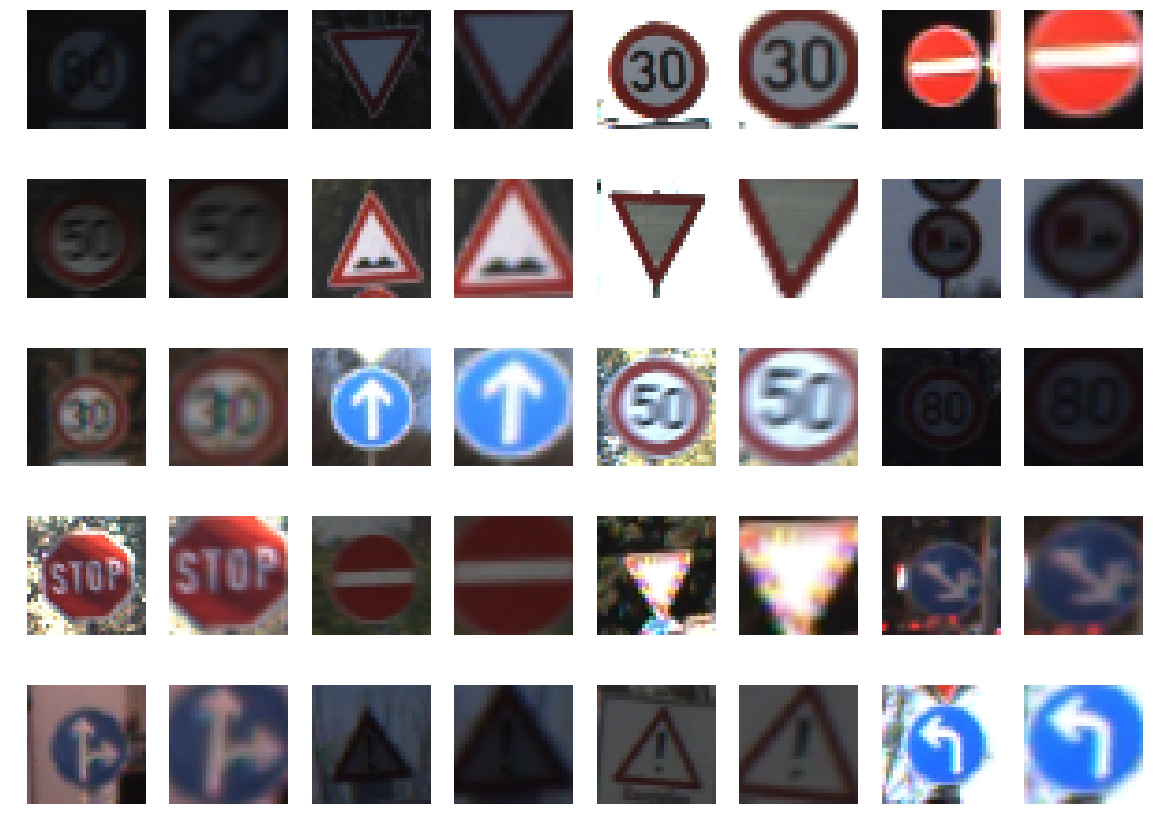

In [36]:
X = X_test
n = 20

f, ax = plt.subplots(int(np.ceil(n/4)), 8, figsize=(20, 15))
for i in range(n):
    
    ii = i//4
    jj = (i % 4)*2
    
    x = X[np.random.randint(len(X))]
    ax[ii, jj].imshow(x)
    ax[ii, jj].axis("off")
    
    stn_output = get_stn_output([x[np.newaxis, :], 0])[0]
    ax[ii, jj + 1].imshow(stn_output[0]/2 + 0.5)
    ax[ii, jj + 1].axis("off")

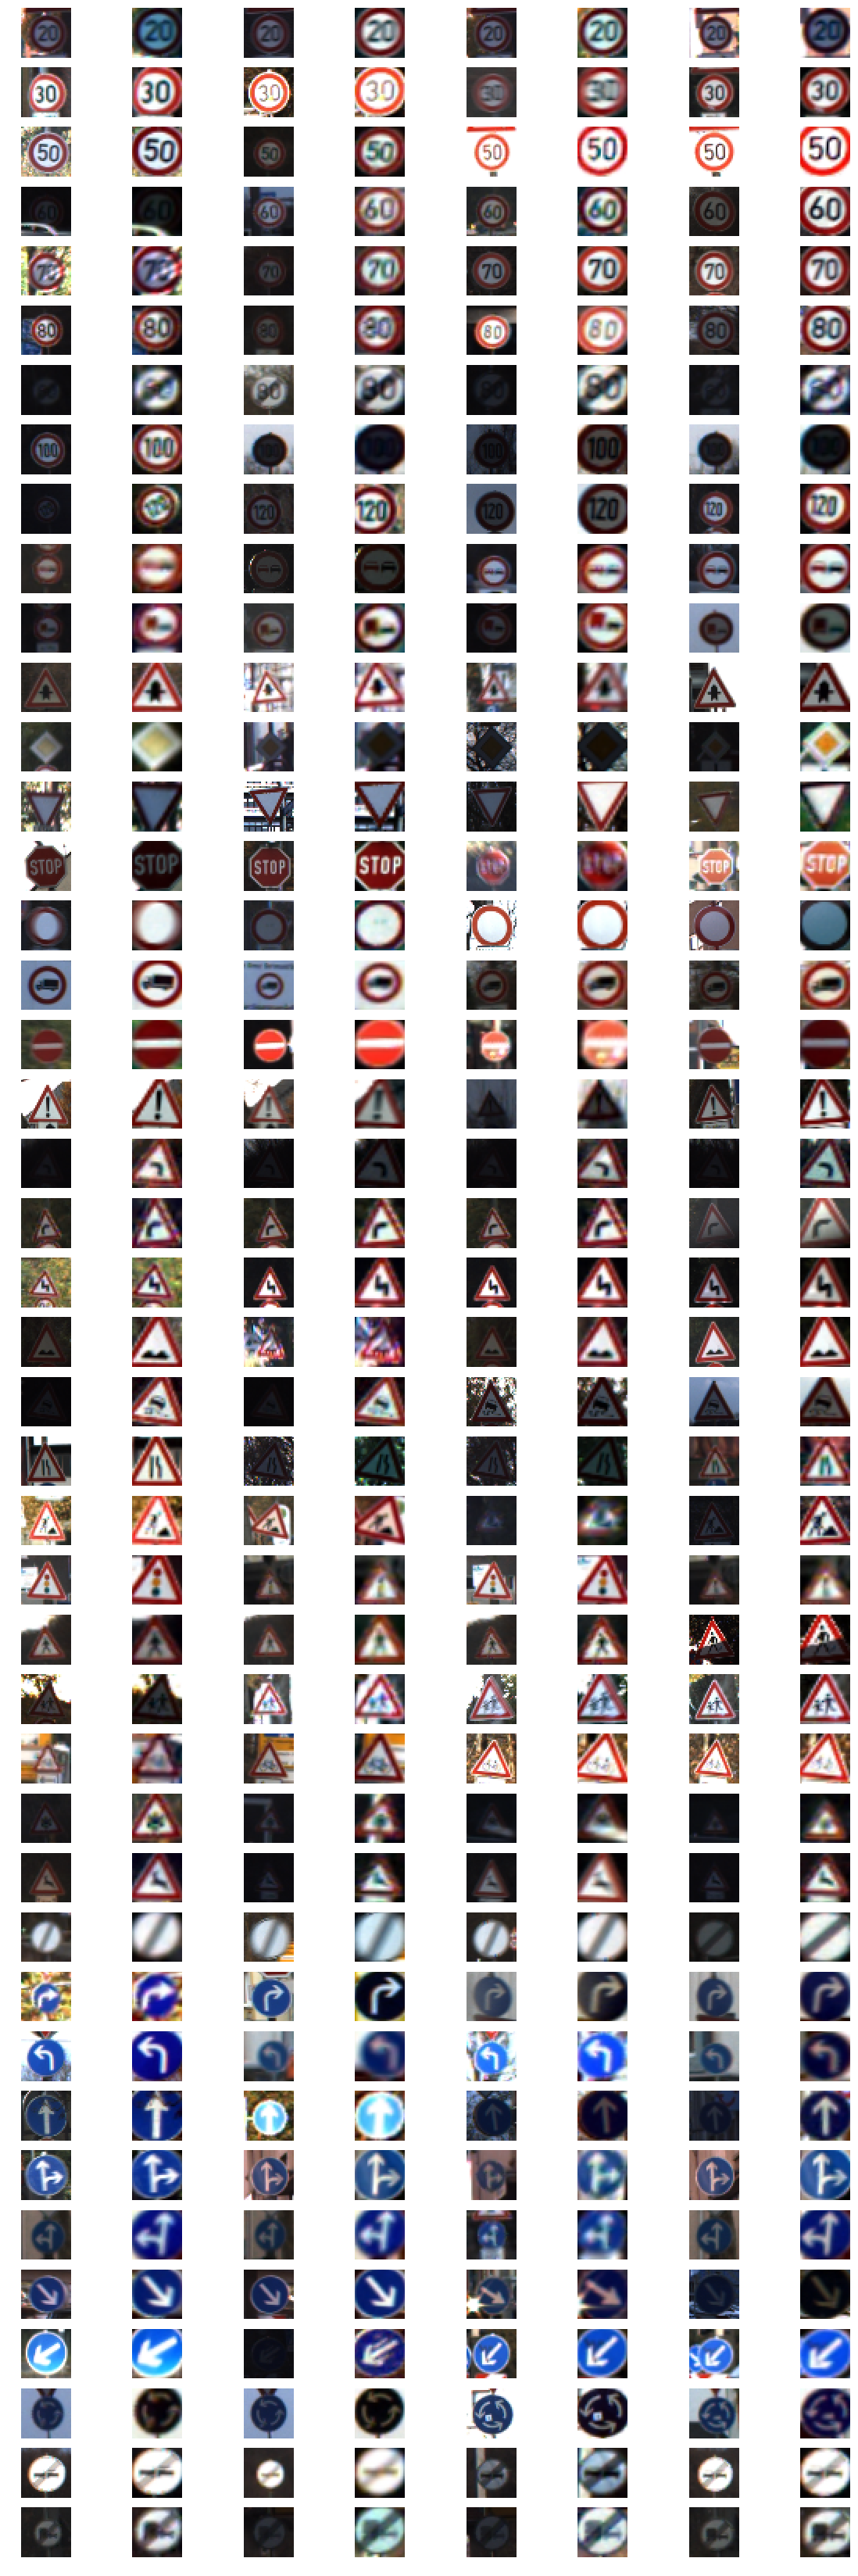

In [37]:
X = X_test
y = y_test

f, ax = plt.subplots(NUM_LABELS, 8, figsize=(20, 60))
for i in range(NUM_LABELS):
    
    ind = np.where(y == i)
    for j in range(4):

        x = X[ind][j]
        ax[i, j*2].imshow(x)
        ax[i, j*2].axis("off")

        stn_output = get_stn_output([x[np.newaxis, :], 0])[0]
        x = np.copy(stn_output[0])
        # x = (x - x.min())/(x.max() - x.min())
        for c in range(3):
            x_c = x[:, :, c]
            x[:, :, c] = (x_c - x_c.min())/(x_c.max() - x_c.min())
        ax[i, j*2 + 1].imshow(x)
        ax[i, j*2 + 1].axis("off")

In [8]:
model.layers[8].locnet.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 26, 26, 16)        2368      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 13, 13, 16)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 9, 9, 32)          12832     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 4, 4, 32)          0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 2, 2, 64)          18496     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 1, 1, 64)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 64)                0         
__________

--- 

In [6]:
model = conv_model_no_color_adjust()
# model = conv_model()
model.load_weights("./keras_weights/stn_v5.hdf5")

get_stn_output = K.function([model.layers[0].input, K.learning_phase()],
                            [model.layers[1].output])

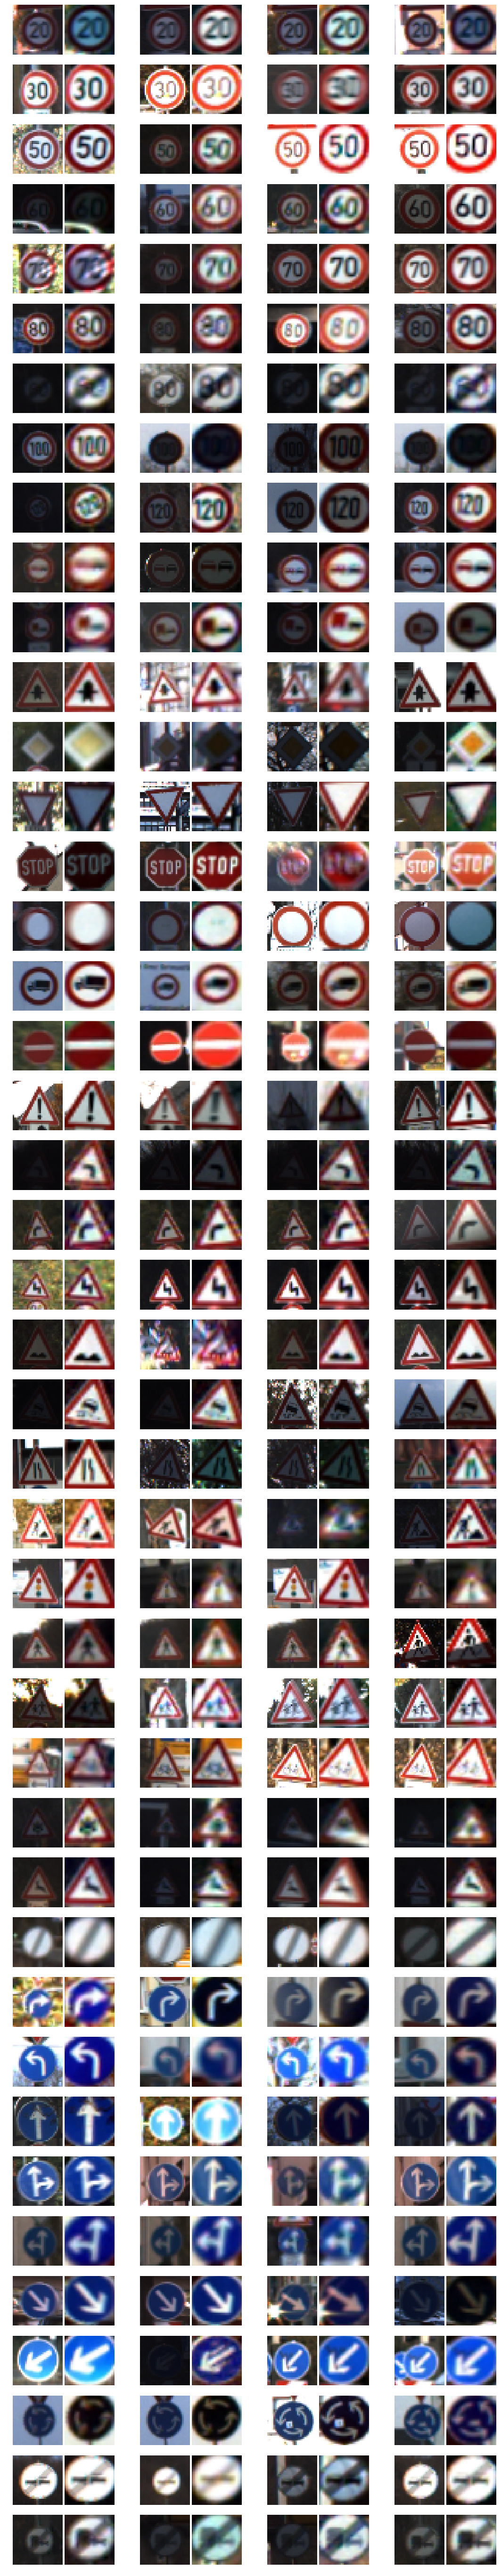

In [43]:
X = X_test
y = y_test

# f, ax = plt.subplots(NUM_LABELS, 8, figsize=(20, 60))
fig = plt.figure(figsize=(15, 100))

for j in range(4):
    
    left = j*0.25 + 0.05
    right = j*0.25 + 0.25
    gs = GridSpec(NUM_LABELS, 2)
    gs.update(left=left, right=right, wspace=0.05)
    for i in range(NUM_LABELS):

        ind = np.where(y == i)
        ax1 = plt.subplot(gs[i, 0])
        ax2 = plt.subplot(gs[i, 1])
        
        x = X[ind][j]
        ax1.imshow(x)
        ax1.axis("off")

        stn_output = get_stn_output([x[np.newaxis, :], 0])[0]
        x = np.copy(stn_output[0])
        # x = (x - x.min())/(x.max() - x.min())
        for c in range(3):
            x_c = x[:, :, c]
            x[:, :, c] = (x_c - x_c.min())/(x_c.max() - x_c.min())
        ax2.imshow(x)
        ax2.axis("off")
        
plt.savefig("stn_v3.png", bbox_inches="tight")

In [10]:
get_st_params = K.function([model.layers[1].locnet.input, K.learning_phase()],
                           [model.layers[1].locnet.output])

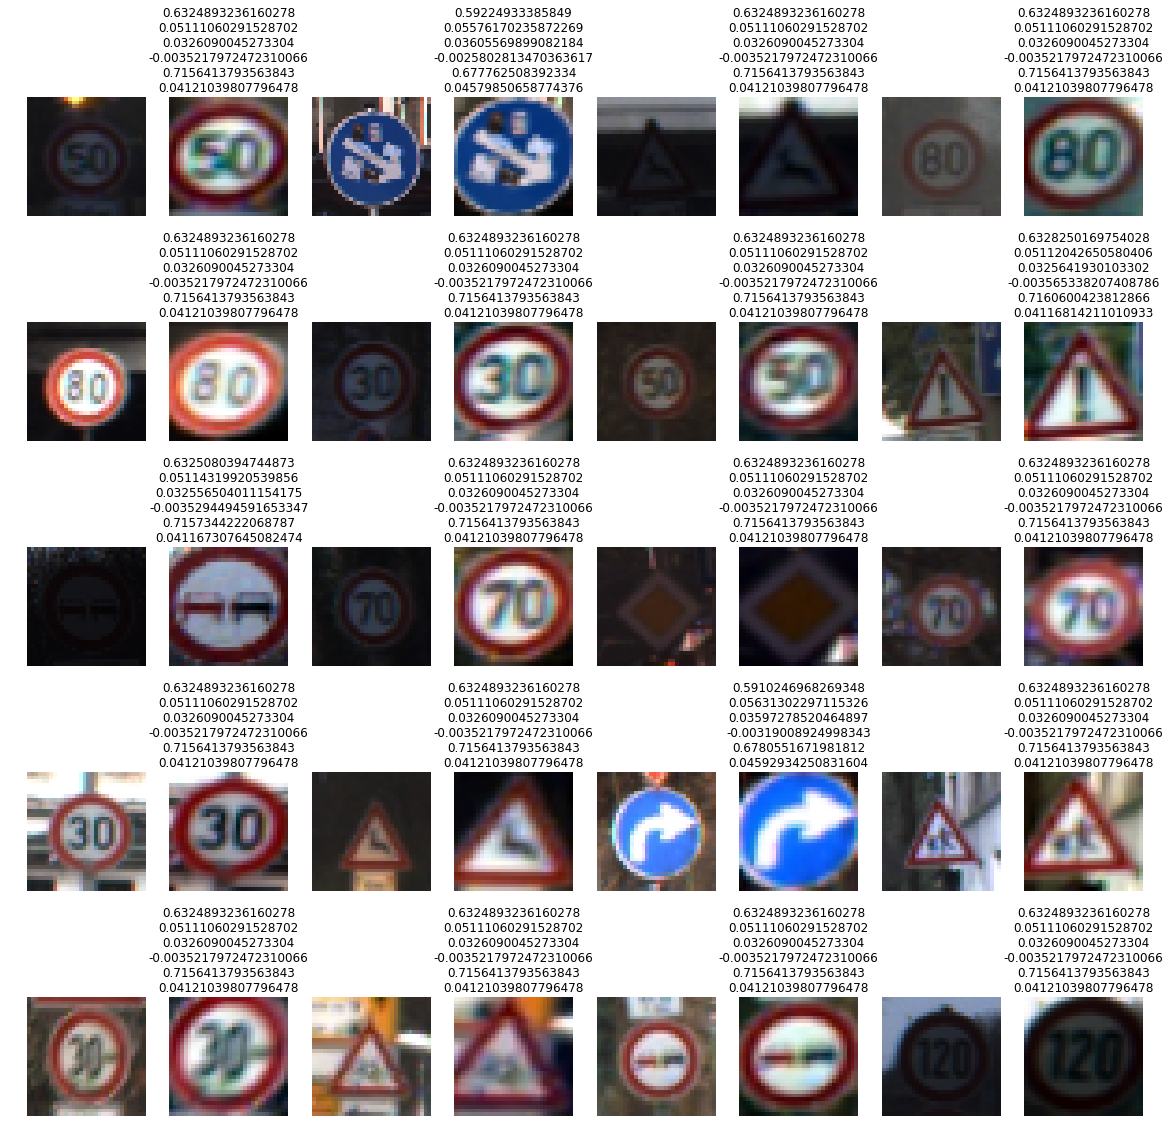

In [11]:
X = X_test
n = 20

f, ax = plt.subplots(int(np.ceil(n/4)), 8, figsize=(20, 20))
for i in range(n):
    
    ii = i//4
    jj = (i % 4)*2
    
    x = X[np.random.randint(len(X))]
    ax[ii, jj].imshow(x)
    ax[ii, jj].axis("off")
    
    param = get_st_params([x[np.newaxis, :], 0])[0]
    stn_output = get_stn_output([x[np.newaxis, :], 0])[0]
    x = np.copy(stn_output[0])
    # x = (x - x.min())/(x.max() - x.min())
    for c in range(3):
        x_c = x[:, :, c]
        x[:, :, c] = (x_c - x_c.min())/(x_c.max() - x_c.min())
    ax[ii, jj + 1].imshow(x)
    ax[ii, jj + 1].axis("off")
    ax[ii, jj + 1].set_title("{}\n{}\n{}\n{}\n{}\n{}".format(*param[0]))

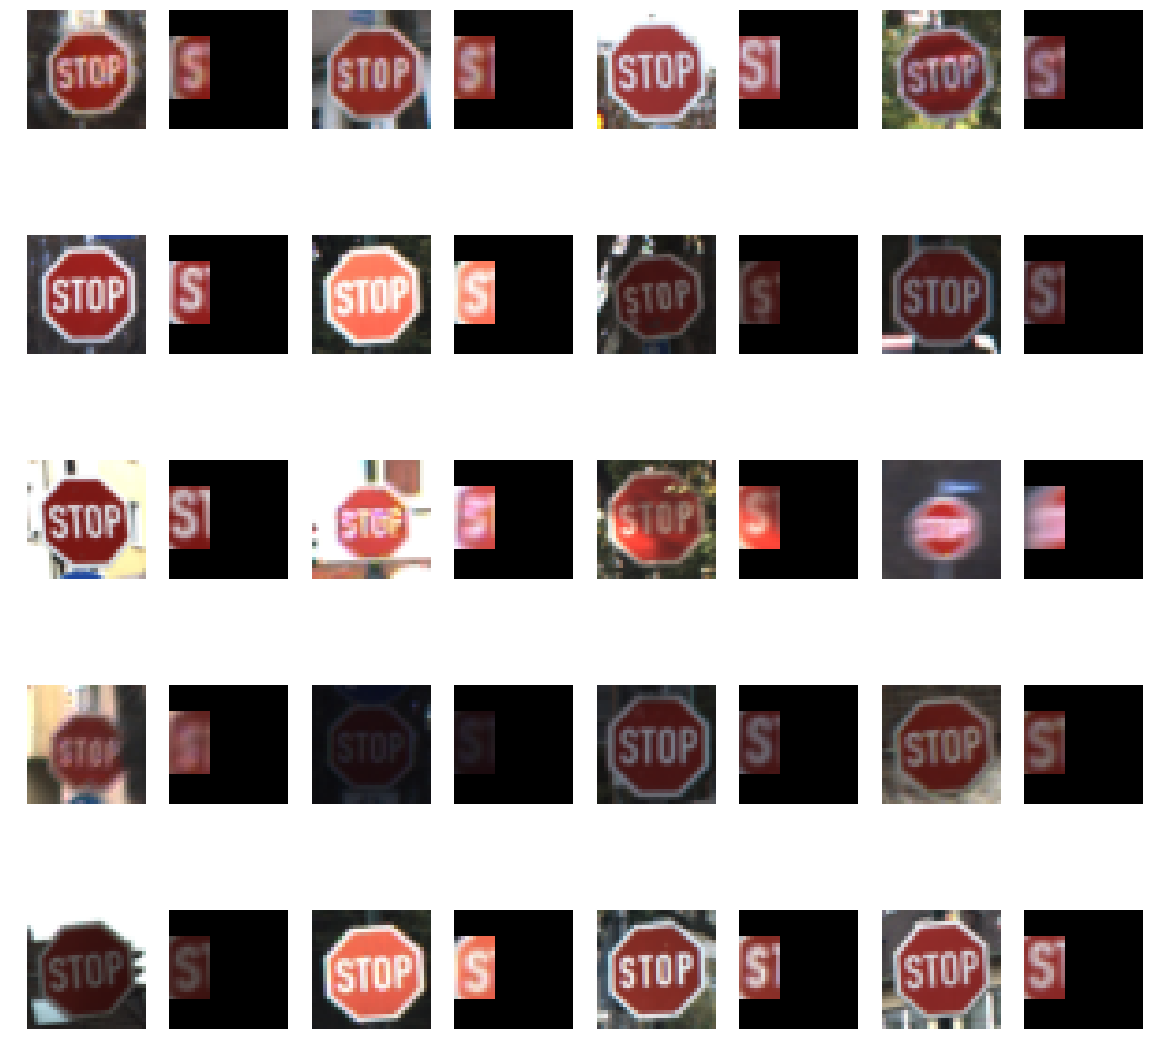

In [20]:
X = X_train
y = y_train
n = 20
y_label = 14
top, bot, left, right = 7, 24, 0, 11
ind = np.where(y == y_label)[0]
random.shuffle(ind)

f, ax = plt.subplots(int(np.ceil(n/4)), 8, figsize=(20, 20))
for i in range(n):
    
    ii = i//4
    jj = (i % 4)*2
    
    x = X[ind][i]
    ax[ii, jj].imshow(x)
    ax[ii, jj].axis("off")
    
    stn_output = get_stn_output([x[np.newaxis, :], 0])[0]
    x = np.copy(stn_output[0])*0.5 + 0.5
    # x = (x - x.min())/(x.max() - x.min())
#     for c in range(3):
#         x_c = x[:, :, c]
#         x[:, :, c] = (x_c - x_c.min())/(x_c.max() - x_c.min())
#     ax[ii, jj].imshow(x)
#     ax[ii, jj].axis("off")
    
    x[:top, :] = 0
    x[bot:, :] = 0
    x[:, :left] = 0
    x[:, right:] = 0
    ax[ii, jj + 1].imshow(x)
    ax[ii, jj + 1].axis("off")

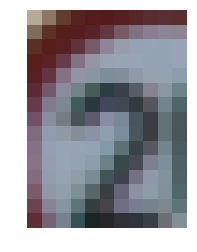

In [5]:
# crop '2': pos = 8, 23, 8, 17
# crop 'S': pos = 9, 23, 1, 9

def get_patch(X, pos):
    """
    Crop all samples in <X> to make a set of patches <X_cropped>
    at the same position <pos>
    """
    
    top, bot, left, right = pos
    X_cropped = np.zeros((X.shape[0], bot - top, right - left, X.shape[3]))
    for i, x in enumerate(X):
        X_cropped[i] = np.copy(x[top:bot, left:right, :])
    return X_cropped

# Test get_patch
X_2 = get_patch(X_train, (7, 22, 7, 18))
plt.imshow(X_2[np.where(y_train == 0)][0])
plt.axis("off")
plt.show()

In [21]:
# Define cropping positions
pos_2 = (7, 23, 5, 17)
pos_0_0 = (7, 23, 15, 27)
pos_3 = (7, 24, 6, 17)
pos_S = (7, 24, 0, 11)
pos_y11 = (11, 27, 9, 21)
# pos_2 = (7, 22, 7, 18)
# pos_S = (4, 19, 0, 9)

---
## Train/test small CNN

In [102]:
model_0_0 = train_simple_cnn(get_stn_output, pos_0_0, 0, 
                           X_train, y_train, 
                           X_val, y_val,
                           save_path="./keras_weights/0_speed20.hdf5")

Train on 34799 samples, validate on 4410 samples
Epoch 1/40
34799/34799 [==============================] - 6s 172us/step - loss: 0.0956 - acc: 0.9700 - val_loss: 0.0422 - val_acc: 0.9930

Epoch 00001: val_loss improved from inf to 0.04223, saving model to ./keras_weights/0_speed20.hdf5
Epoch 2/40
34799/34799 [==============================] - 3s 88us/step - loss: 0.0365 - acc: 0.9921 - val_loss: 0.0390 - val_acc: 0.9932

Epoch 00002: val_loss improved from 0.04223 to 0.03905, saving model to ./keras_weights/0_speed20.hdf5
Epoch 3/40
34799/34799 [==============================] - 3s 88us/step - loss: 0.0319 - acc: 0.9928 - val_loss: 0.0400 - val_acc: 0.9927

Epoch 00003: val_loss did not improve from 0.03905
Epoch 4/40
34799/34799 [==============================] - 3s 88us/step - loss: 0.0285 - acc: 0.9935 - val_loss: 0.0394 - val_acc: 0.9930

Epoch 00004: val_loss did not improve from 0.03905
Epoch 5/40
34799/34799 [==============================] - 3s 90us/step - loss: 0.0265 - acc: 0

In [103]:
# ***** transfer, eq, lr 1e-4
print(eval_simple_cnn(model_0_0, get_stn_output, 0, X_train, y_train))
print(eval_simple_cnn(model_0_0, get_stn_output, 0, X_val, y_val))
print(eval_simple_cnn(model_0_0, get_stn_output, 0, X_test, y_test))

(0.8812034828587029, 0.1192697651578613, 0.027777777777777776)
(0.8861678004535147, 0.1139269406392694, 0.1)
(0.8730007917656374, 0.12577565632458235, 0.38333333333333336)


In [91]:
model_y11 = train_simple_cnn(get_stn_output, pos_y11, 11, 
                           X_train, y_train, 
                           X_val, y_val,
                           save_path="./keras_weights/rightway.hdf5")

Train on 34799 samples, validate on 4410 samples
Epoch 1/40
34799/34799 [==============================] - 5s 153us/step - loss: 0.1692 - acc: 0.9401 - val_loss: 0.0432 - val_acc: 0.9862

Epoch 00001: val_loss improved from inf to 0.04320, saving model to ./keras_weights/rightway.hdf5
Epoch 2/40
34799/34799 [==============================] - 3s 87us/step - loss: 0.0675 - acc: 0.9817 - val_loss: 0.0358 - val_acc: 0.9875

Epoch 00002: val_loss improved from 0.04320 to 0.03584, saving model to ./keras_weights/rightway.hdf5
Epoch 3/40
34799/34799 [==============================] - 3s 87us/step - loss: 0.0546 - acc: 0.9861 - val_loss: 0.0308 - val_acc: 0.9896

Epoch 00003: val_loss improved from 0.03584 to 0.03085, saving model to ./keras_weights/rightway.hdf5
Epoch 4/40
34799/34799 [==============================] - 3s 87us/step - loss: 0.0496 - acc: 0.9879 - val_loss: 0.0266 - val_acc: 0.9912

Epoch 00004: val_loss improved from 0.03085 to 0.02655, saving model to ./keras_weights/rightway

In [93]:
# ***** transfer, eq, lr 1e-4
print(eval_simple_cnn(model_y11, get_stn_output, 11, X_train, y_train))
print(eval_simple_cnn(model_y11, get_stn_output, 11, X_val, y_val))
print(eval_simple_cnn(model_y11, get_stn_output, 11, X_test, y_test))

(0.9927009396821748, 0.007285378691010735, 0.007692307692307693)
(0.9877551020408163, 0.01267605633802817, 0.0)
(0.9865399841646872, 0.011547911547911549, 0.06904761904761905)


In [13]:
model_3 = train_simple_cnn(get_stn_output, pos_3, 1, 
                           X_train, y_train, 
                           X_val, y_val,
                           save_path="./keras_weights/1_3.hdf5")

Epoch 1/40
544/543 [==============================] - 31s 56ms/step - loss: 0.3228 - acc: 0.8601 - val_loss: 0.1142 - val_acc: 0.9540

Epoch 00001: val_loss improved from inf to 0.11421, saving model to ./keras_weights/1_3_x.hdf5
Epoch 2/40
544/543 [==============================] - 30s 54ms/step - loss: 0.1666 - acc: 0.9360 - val_loss: 0.0679 - val_acc: 0.9728

Epoch 00002: val_loss improved from 0.11421 to 0.06794, saving model to ./keras_weights/1_3_x.hdf5
Epoch 3/40
544/543 [==============================] - 30s 56ms/step - loss: 0.1171 - acc: 0.9577 - val_loss: 0.0498 - val_acc: 0.9808

Epoch 00003: val_loss improved from 0.06794 to 0.04979, saving model to ./keras_weights/1_3_x.hdf5
Epoch 4/40
544/543 [==============================] - 31s 56ms/step - loss: 0.0941 - acc: 0.9670 - val_loss: 0.0416 - val_acc: 0.9864

Epoch 00004: val_loss improved from 0.04979 to 0.04159, saving model to ./keras_weights/1_3_x.hdf5
Epoch 5/40
544/543 [==============================] - 29s 54ms/step 

KeyboardInterrupt: 

In [49]:
# 
print(eval_simple_cnn(model_3, get_stn_output, 1, X_train, y_train))
print(eval_simple_cnn(model_3, get_stn_output, 1, X_val, y_val))
print(eval_simple_cnn(model_3, get_stn_output, 1, X_test, y_test))

(0.9989080145981206, 0.0011578658703799629, 0.0)
(0.9970521541950114, 0.0028776978417266188, 0.004166666666666667)
(0.9956452889944576, 0.004030226700251889, 0.009722222222222222)


In [22]:
model_S = train_simple_cnn(get_stn_output, pos_S, 14, 
                           X_train, y_train, 
                           X_val, y_val,
                           save_path="./keras_weights/14_S.hdf5")

Epoch 1/40
544/543 [==============================] - 33s 61ms/step - loss: 0.1055 - acc: 0.9595 - val_loss: 0.0349 - val_acc: 0.9887

Epoch 00001: val_loss improved from inf to 0.03487, saving model to ./keras_weights/14_S.hdf5
Epoch 2/40
544/543 [==============================] - 30s 55ms/step - loss: 0.0267 - acc: 0.9915 - val_loss: 0.0370 - val_acc: 0.9912

Epoch 00002: val_loss did not improve from 0.03487
Epoch 3/40
544/543 [==============================] - 32s 58ms/step - loss: 0.0156 - acc: 0.9952 - val_loss: 0.0248 - val_acc: 0.9914

Epoch 00003: val_loss improved from 0.03487 to 0.02477, saving model to ./keras_weights/14_S.hdf5
Epoch 4/40
544/543 [==============================] - 30s 55ms/step - loss: 0.0096 - acc: 0.9973 - val_loss: 0.0142 - val_acc: 0.9904

Epoch 00004: val_loss improved from 0.02477 to 0.01421, saving model to ./keras_weights/14_S.hdf5
Epoch 5/40
544/543 [==============================] - 32s 58ms/step - loss: 0.0068 - acc: 0.9980 - val_loss: 0.0846 - v

In [23]:
# best
print(eval_simple_cnn(model_S, get_stn_output, 14, X_train, y_train))
print(eval_simple_cnn(model_S, get_stn_output, 14, X_val, y_val))
print(eval_simple_cnn(model_S, get_stn_output, 14, X_test, y_test))

(0.9994540072990603, 0.0005570377319768976, 0.0)
(0.9956916099773243, 0.004166666666666667, 0.011111111111111112)
(0.9978622327790974, 0.002103559870550162, 0.003703703703703704)


In [74]:
# ***** transfer, eq (r=3), lr 1e-4
print(eval_simple_cnn(model_S, get_stn_output, 14, X_train, y_train))
print(eval_simple_cnn(model_S, get_stn_output, 14, X_val, y_val))
print(eval_simple_cnn(model_S, get_stn_output, 14, X_test, y_test))

(0.9963792062990315, 0.003606086370166232, 0.004347826086956522)
(0.992517006802721, 0.00625, 0.06666666666666667)
(0.9932699920823437, 0.005906148867313916, 0.044444444444444446)


In [64]:
# ***** transfer, eq, lr 1e-4
print(eval_simple_cnn(model_S, get_stn_output, 14, X_train, y_train))
print(eval_simple_cnn(model_S, get_stn_output, 14, X_val, y_val))
print(eval_simple_cnn(model_S, get_stn_output, 14, X_test, y_test))

(0.9891376188970947, 0.011082119088803542, 0.0)
(0.9752834467120182, 0.024537037037037038, 0.03333333333333333)
(0.9889944576405384, 0.010922330097087379, 0.014814814814814815)


In [15]:
model_2 = train_simple_cnn(get_stn_output, pos_2, 0, 
                           X_train, y_train, 
                           X_val, y_val,
                           save_path="./keras_weights/2_speed20_v10.hdf5")

Epoch 1/40
544/543 [==============================] - 33s 62ms/step - loss: 0.1662 - acc: 0.9368 - val_loss: 0.0466 - val_acc: 0.9751

Epoch 00001: val_loss improved from inf to 0.04662, saving model to ./keras_weights/2_speed20_v10.hdf5
Epoch 2/40
544/543 [==============================] - 30s 56ms/step - loss: 0.0837 - acc: 0.9709 - val_loss: 0.0315 - val_acc: 0.9782

Epoch 00002: val_loss improved from 0.04662 to 0.03146, saving model to ./keras_weights/2_speed20_v10.hdf5
Epoch 3/40
544/543 [==============================] - 31s 58ms/step - loss: 0.0665 - acc: 0.9786 - val_loss: 0.0273 - val_acc: 0.9786

Epoch 00003: val_loss improved from 0.03146 to 0.02728, saving model to ./keras_weights/2_speed20_v10.hdf5
Epoch 4/40
544/543 [==============================] - 31s 57ms/step - loss: 0.0592 - acc: 0.9808 - val_loss: 0.0243 - val_acc: 0.9789

Epoch 00004: val_loss improved from 0.02728 to 0.02426, saving model to ./keras_weights/2_speed20_v10.hdf5
Epoch 5/40
544/543 [================

In [16]:
# Correct balance (r=1)
print(eval_simple_cnn(model_2, get_stn_output, 0, X_train, y_train))
print(eval_simple_cnn(model_2, get_stn_output, 0, X_val, y_val))
print(eval_simple_cnn(model_2, get_stn_output, 0, X_test, y_test))

(0.9968677260840829, 0.003148560039284786, 0.0)
(0.999546485260771, 0.00045662100456621003, 0.0)
(0.9924782264449723, 0.005171042163882259, 0.5)


In [110]:
# ***** transfer, eq (r=10), lr 1e-4
print(eval_simple_cnn(model_2, get_stn_output, 0, X_train, y_train))
print(eval_simple_cnn(model_2, get_stn_output, 0, X_val, y_val))
print(eval_simple_cnn(model_2, get_stn_output, 0, X_test, y_test))

(0.9971263542055806, 0.0028885871920043904, 0.0)
(0.9979591836734694, 0.0018264840182648401, 0.03333333333333333)
(0.9922406967537609, 0.00771678599840891, 0.016666666666666666)


In [52]:
# ***** transfer, eq, lr 1e-4
print(eval_simple_cnn(model_2, get_stn_output, 0, X_train, y_train))
print(eval_simple_cnn(model_2, get_stn_output, 0, X_val, y_val))
print(eval_simple_cnn(model_2, get_stn_output, 0, X_test, y_test))

(0.9730739389062905, 0.027037176117161096, 0.005555555555555556)
(0.9863945578231292, 0.013242009132420091, 0.06666666666666667)
(0.9635787806809184, 0.03659506762132061, 0.0)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


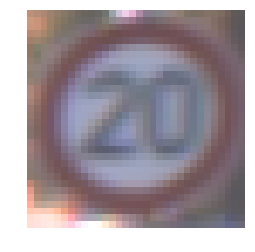

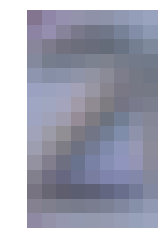

[ 1.1460507 -1.0914409]


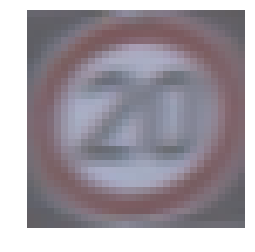

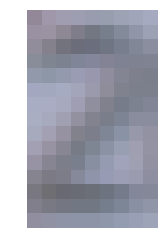

[ 0.82222193 -0.7004645 ]


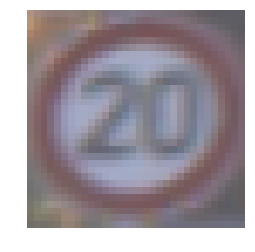

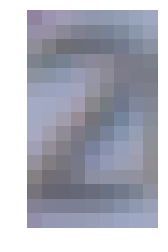

[ 0.92203    -0.86855876]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


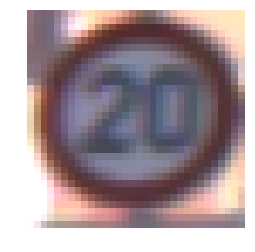

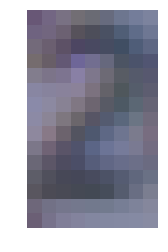

[ 2.8942792 -2.3722243]


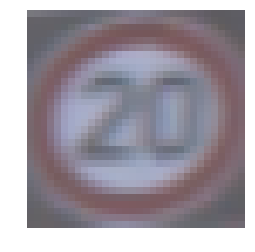

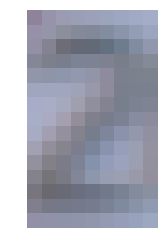

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[ 0.69797087 -0.81188107]


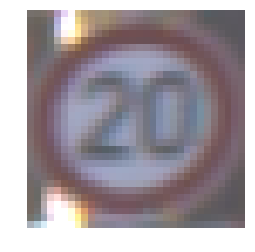

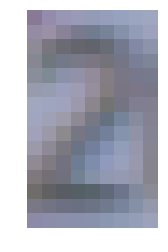

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[-0.18243192  0.00495511]


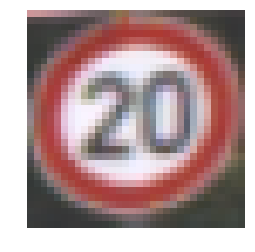

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


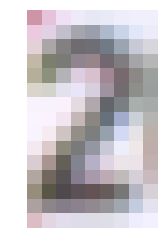

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[-2.523607   1.8657633]


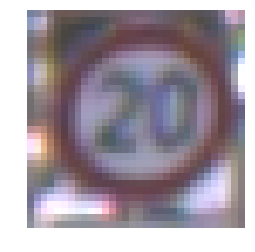

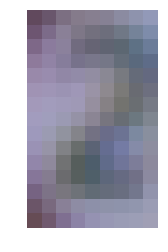

[ 2.7304847 -2.1502137]


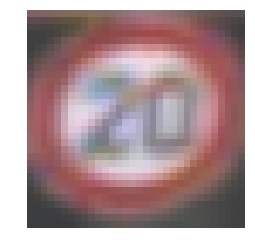

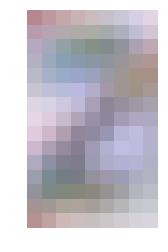

[ 1.4481025 -1.588954 ]


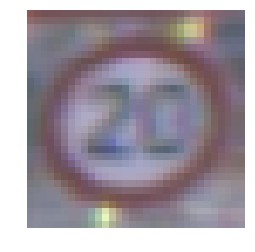

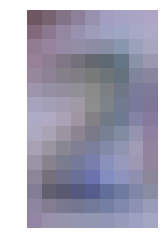

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[ 0.6423258 -0.7094046]


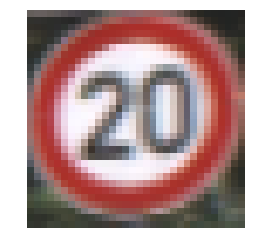

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


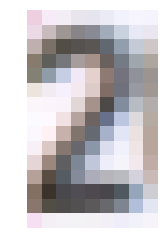

[-3.8010995  2.9277155]


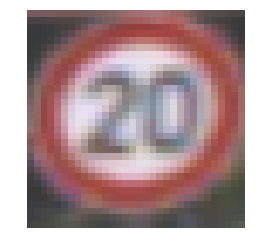

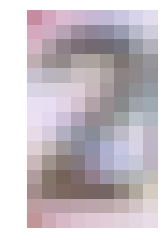

[ 0.1634678  -0.37408134]


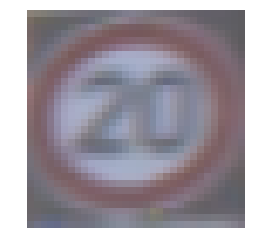

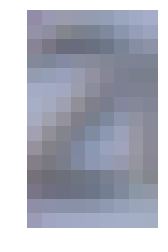

[ 0.4112297  -0.56815505]


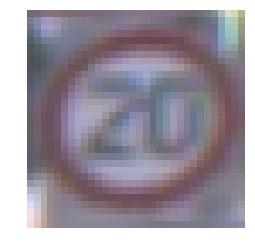

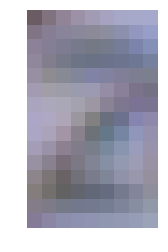

[ 0.1334721  -0.30891436]


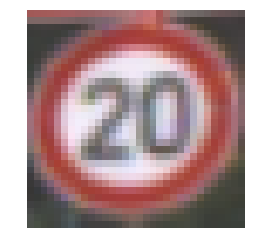

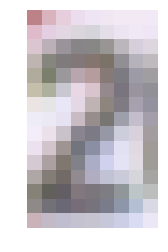

[-2.2248375  1.4768543]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


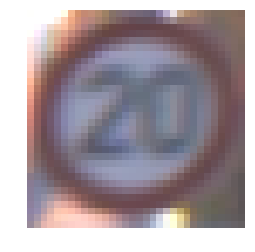

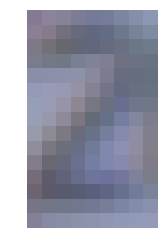

[ 1.0267386 -1.0210723]


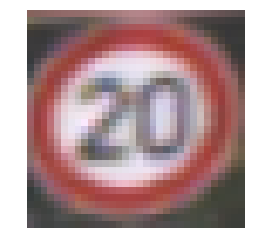

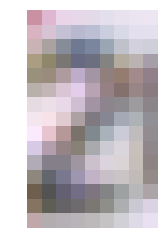

[-2.3219943  1.7447642]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


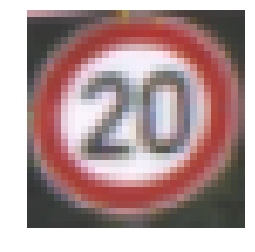

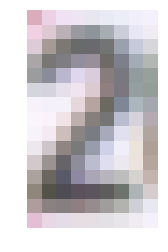

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[-2.234129   1.6814032]


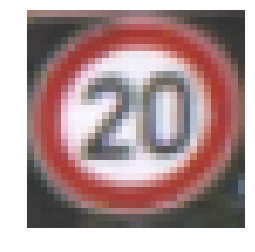

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


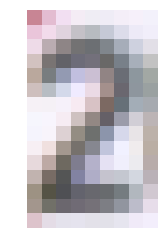

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[-2.8252923  2.3408914]


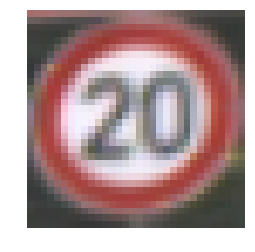

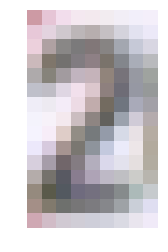

[-2.215758   1.8033059]


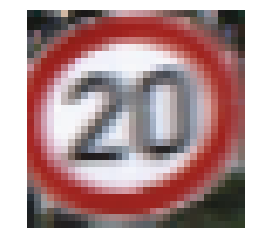

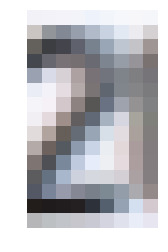

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[-2.7644053  1.5216446]


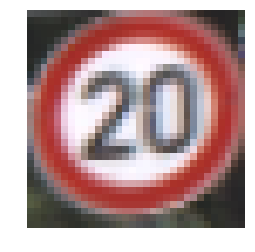

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


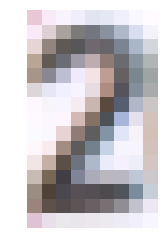

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[-2.3876157  2.2154431]


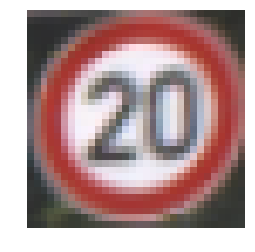

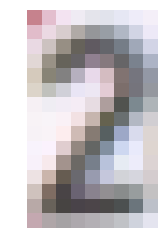

[-0.59546834  0.34625578]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


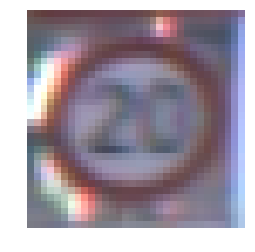

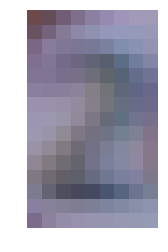

[ 0.1522527  -0.50090057]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


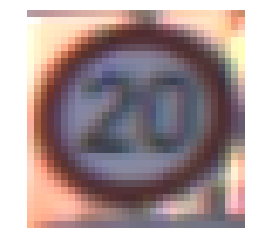

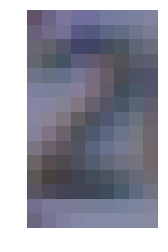

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[ 2.7552843 -2.5105953]


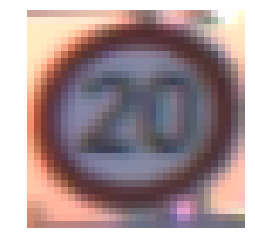

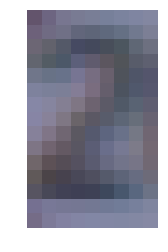

[ 2.4852717 -2.2714055]


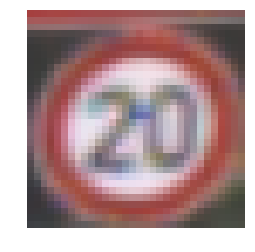

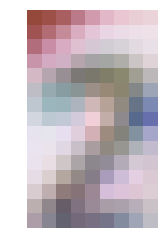

[ 2.1934817 -1.946604 ]


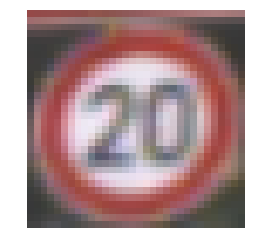

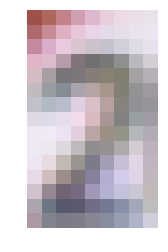

[ 0.08444455 -0.7971096 ]


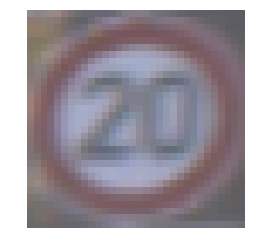

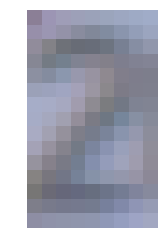

[ 0.8281234  -0.84234965]


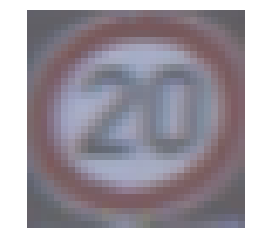

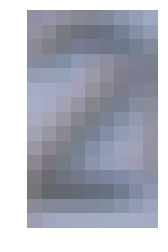

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[ 0.7656475 -0.6196582]


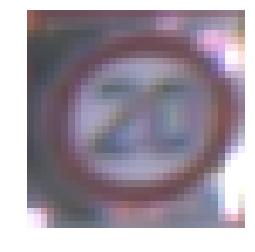

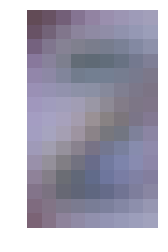

[ 2.2035482 -2.013373 ]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


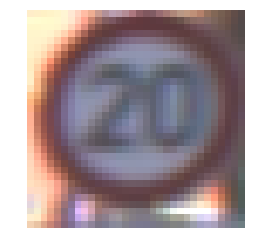

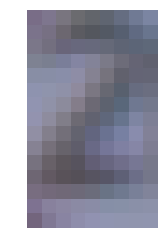

[ 2.264561  -1.7256367]


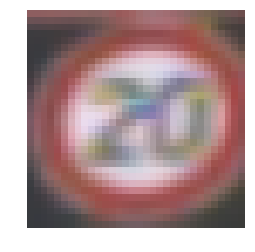

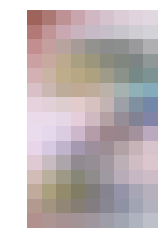

[ 3.6244688 -3.2271643]


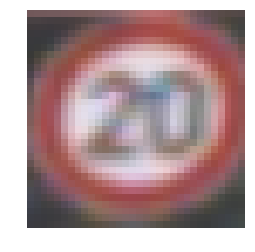

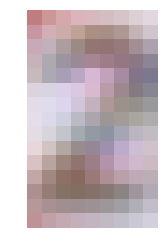

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[ 1.8287948 -1.58344  ]


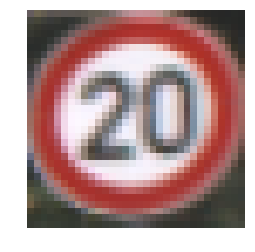

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


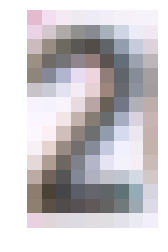

[-3.3915906  2.9981937]


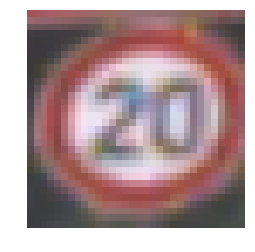

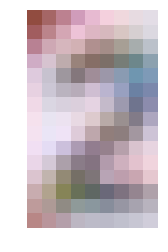

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[ 1.6096686 -1.4251764]


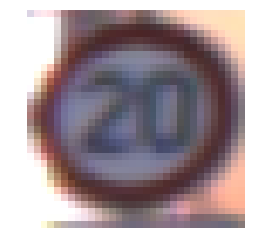

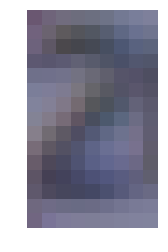

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[ 4.2187476 -3.6052516]


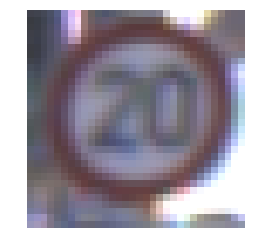

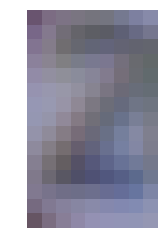

[ 3.4082077 -2.9721549]


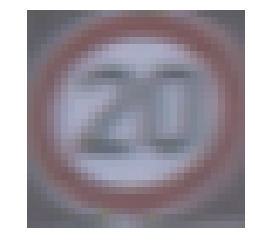

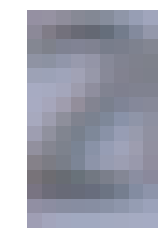

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[ 0.31259054 -0.19954428]


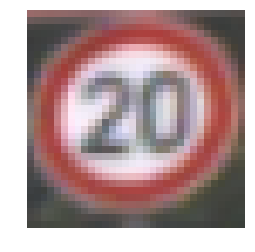

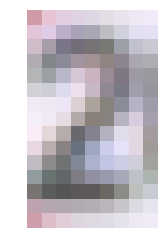

[-2.0893373  1.4216063]


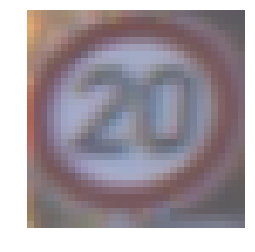

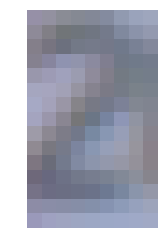

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[ 0.3187041  -0.49504802]


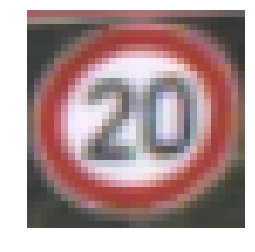

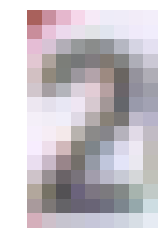

[-2.3422585  1.7066702]


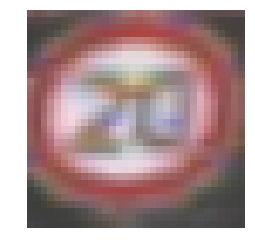

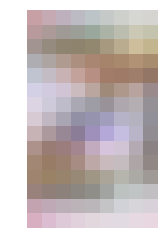

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[ 1.5711845 -1.2120838]


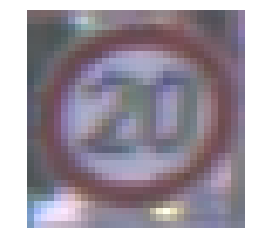

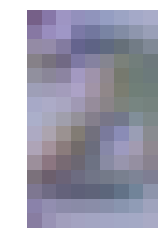

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[ 0.30409583 -0.528397  ]


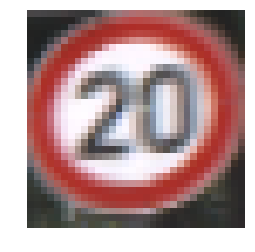

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


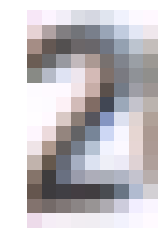

[-3.6319783  2.483928 ]


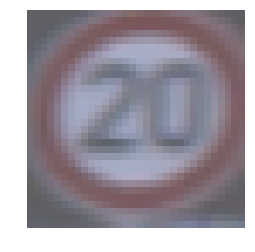

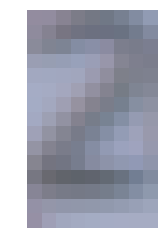

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[ 0.55494875 -0.07322871]


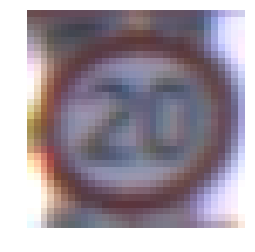

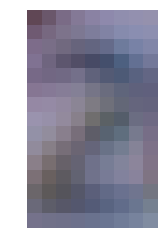

[ 1.2855923 -1.5107834]


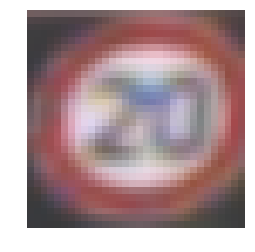

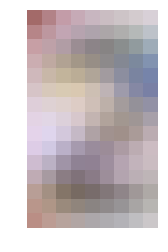

[ 3.5982137 -2.9714603]


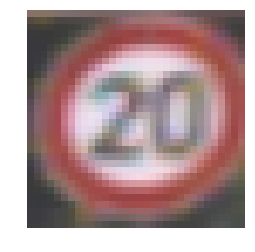

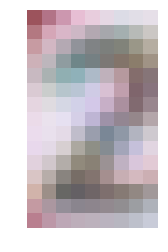

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[ 2.8051612 -2.4569983]


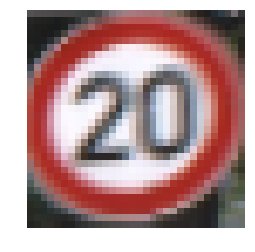

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


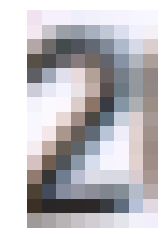

[-4.19695    2.7100148]


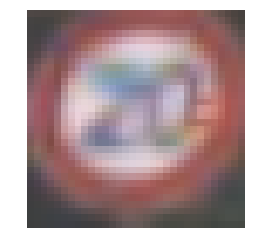

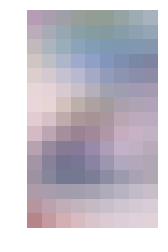

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[ 4.018643  -4.0232034]


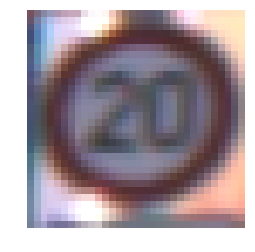

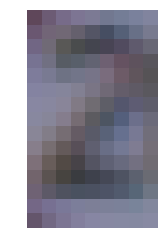

[ 3.287548  -2.9504352]


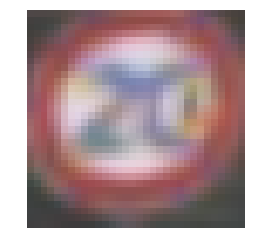

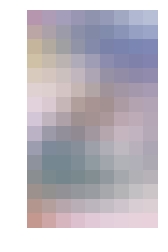

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[ 3.6193557 -3.6454282]


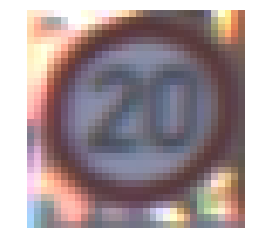

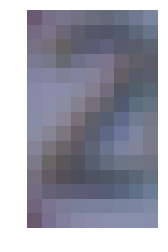

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[ 3.6652899 -3.004532 ]


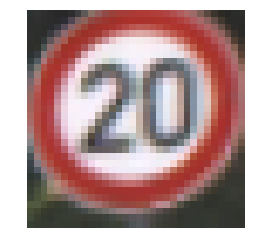

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


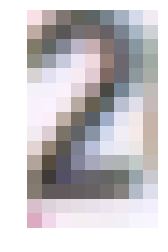

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[-2.153166   1.4842534]


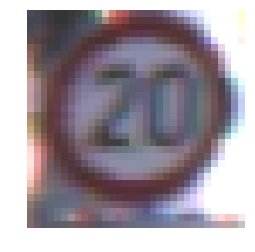

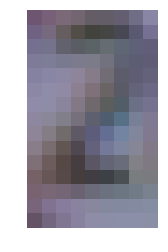

[ 1.5814235  -0.82909507]


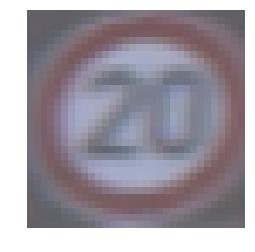

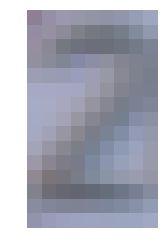

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[ 1.4605834 -1.3485734]


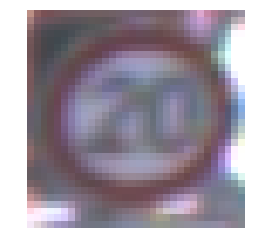

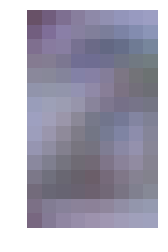

[ 1.4227711 -1.2459943]


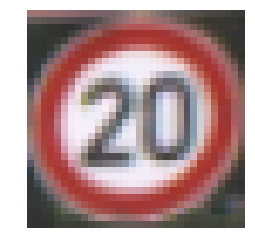

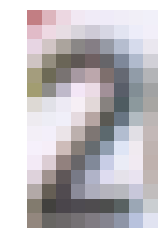

[-2.9699996  1.4177778]


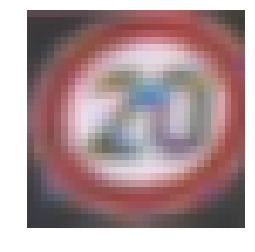

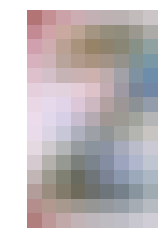

[ 3.11987   -2.6279066]


In [48]:
for x in X_test[np.where(y_test == 0)]:
#for x in X_train[np.where(y_train == 0)][:40]:
    
    x_stn = get_stn_output([x[np.newaxis, :], 0])[0][0]
    x_stn -= np.mean(x_stn)
#     x_p = get_patch(x_stn[np.newaxis, :], pos_2)[0]
    y = model_2.predict(x_stn[np.newaxis, :])[0]
    #if np.argmax(y) == 0:
    plt.imshow(x_stn*.5 + .5)
    plt.axis("off")
    plt.show()

    patch = get_patch(x_stn[np.newaxis, :], pos_2)[0]
    plt.imshow(patch*.5 + .5)
    plt.axis("off")
    plt.show()

    print(y)
    #print(1 / (1 + np.exp(-y)))

In [37]:
np.mean(X_train, axis=(1,2,3), keepdims=True).shape

(34799, 1, 1, 1)

---
## Test robustness

In [24]:
# Load and set up all models
clf = conv_model_no_color_adjust()
clf.load_weights("./keras_weights/stn_v5.hdf5")
get_stn_output = K.function([clf.layers[0].input, K.learning_phase()],
                            [clf.layers[1].output])
detect_3 = create_simple_cnn(pos_3)
detect_3.load_weights("./keras_weights/1_3.hdf5")
detect_S = create_simple_cnn(pos_S)
detect_S.load_weights("./keras_weights/14_S.hdf5")

{'name': 'dense_21',
 'trainable': True,
 'units': 43,
 'activation': 'softmax',
 'use_bias': True,
 'kernel_initializer': {'class_name': 'VarianceScaling',
  'config': {'scale': 1.0,
   'mode': 'fan_avg',
   'distribution': 'uniform',
   'seed': None}},
 'bias_initializer': {'class_name': 'Zeros', 'config': {}},
 'kernel_regularizer': None,
 'bias_regularizer': None,
 'activity_regularizer': None,
 'kernel_constraint': None,
 'bias_constraint': None}